In [1]:
import settings
import os


import pandas as pd
train_data = pd.read_csv(os.path.join(settings.PROCESSED_DATA_DIR, "training_data_processed.csv"), index_col =0)
submission_data = pd.read_csv(os.path.join(settings.PROCESSED_DATA_DIR, "test_data_processed.csv"), index_col =0)

In [2]:
features = list(train_data.columns)
print features
features.remove('status_group')

['funder', 'gps_height', 'installer', 'longitude', 'latitude', 'basin', 'region_code', 'ward', 'population', 'public_meeting', 'scheme_management', 'permit', 'construction_year', 'extraction_type', 'management', 'payment_type', 'water_quality', 'quantity', 'source', 'waterpoint_type', 'area', 'year_recorded', 'day_recorded', 'status_group']


In [3]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
for feature in features:
    train_data[feature] = std_scaler.fit_transform(train_data[feature])

C:\Users\ra18m\Anaconda\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ra18m\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\ra18m\Anaconda\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ra18m\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data eith

In [4]:
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

### Correlation coefficients :

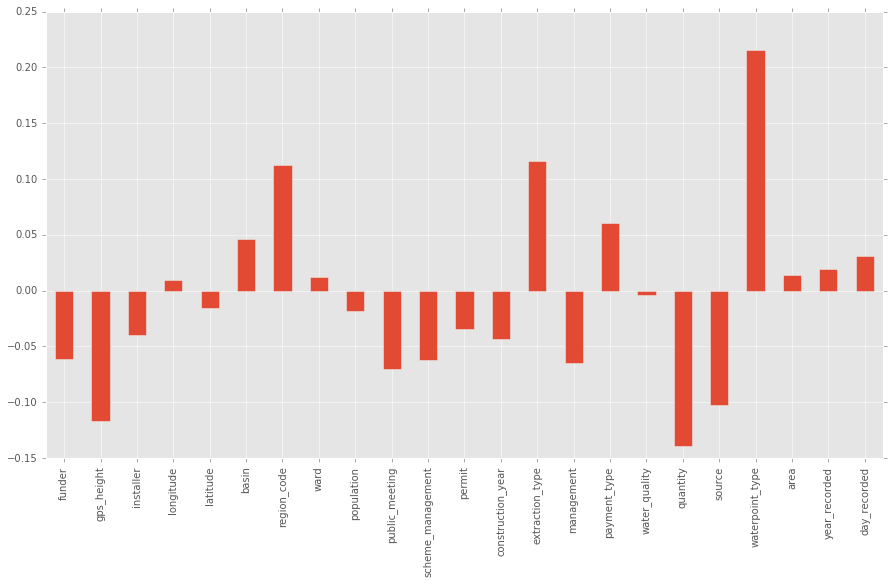

In [5]:
train_data.loc[(train_data['status_group'] == 0) | (train_data['status_group'] == 1)].corr()['status_group'][:-1].plot(kind='bar',stacked=True, figsize=(15,8))


In [6]:
train_data.head()

,funder,gps_height,installer,longitude,latitude,basin,region_code,ward,population,public_meeting,...,management,payment_type,water_quality,quantity,source,waterpoint_type,area,year_recorded,day_recorded,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,0.913728,1.041235,1.299952,-0.058535,-1.443921,-1.244266,-0.244331,0.618717,-0.150403,0.304989,...,-0.134814,-1.547892,0.272735,-0.405305,0.955412,-0.883628,-0.456612,-0.961305,-0.490181,0
8776,-0.693271,1.054220,-0.417670,-0.150958,1.301376,-0.031179,0.267400,0.873303,0.212283,0.304989,...,1.820820,-0.458620,0.272735,0.838865,-0.520276,-0.883628,-0.456612,1.124750,-0.578169,0
34310,-0.063628,0.025525,2.224584,0.915626,0.705276,0.373184,0.324259,0.953699,0.148654,0.304989,...,-0.134814,1.175287,0.272735,-0.405305,-2.979756,-0.322280,-0.456612,1.124750,-0.677156,0
67743,1.560600,-0.584768,1.882940,1.311649,-1.906515,1.181908,4.247528,0.864929,-0.258573,0.304989,...,-0.134814,-0.458620,0.272735,-1.649474,-1.504068,-0.322280,-0.456612,1.124750,-0.985115,1
19728,-1.479542,-0.964216,-1.165212,-1.528808,1.416086,-0.031179,0.153682,1.059218,-0.381589,0.304989,...,-3.068266,-0.458620,0.272735,2.083035,-0.520276,-0.883628,-0.456612,-0.961305,0.840642,0


In [7]:
from sklearn.cross_validation import train_test_split    
train_set, test_set, train_set_labels, test_set_labels = train_test_split(train_data[features], train_data['status_group'].values, test_size=0.2, random_state=1)

## k-Nearest Neighbors

I start with a kNN model to see if i could accurately predict the operation of pumps given their similarities to other pumps.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [9]:


n_neighbors = [1,5,10,20]
for k in n_neighbors :
    knn_clf = KNeighborsClassifier(n_neighbors = k)
    knn_clf.fit(train_set,train_set_labels)
    train_predictions = knn_clf.predict(train_set)
    test_predictions = knn_clf.predict(test_set)
    print accuracy_score(train_predictions,train_set_labels),accuracy_score(test_predictions,test_set_labels)

0.998505860814 0.743771043771
0.829878574886 0.760437710438
0.791977945664 0.752777777778
0.757928407584 0.728282828283


| K | Accuracy on Training Set | Accuracy on Test Set  |
| :-------------: |:-------------:| :-----:|
| 1      | 99.80% | 74.94% |
| 5      | 83.12%     |   76.42% |
| 10 | 79.33%      |    75.61% |
| 20 | 76.28%      |    79.93% |

The best model is with k=5, but the accuracy is still low, so i will try SVM next.

## Logistic Regression

In order to optimize the logistic regression classifier, I will play around the penalty parameter (setting it to 'l1' or 'l2') and the C parameter (Inverse of regularization strength).

In [10]:
from sklearn.linear_model import LogisticRegression
c_values = [0.001,0.01,0.1,0.3,1,3,10]
penalites = ['l1','l2']
for p in penalites:
    for c in c_values:
        lr_clf = LogisticRegression(penalty=p, C=c)
        lr_clf.fit(train_set,train_set_labels)
        train_predictions = lr_clf.predict(train_set)
        test_predictions = lr_clf.predict(test_set)
        print p, c, accuracy_score(train_predictions,train_set_labels),accuracy_score(test_predictions,test_set_labels)

l1 0.001 0.590458553421 0.582744107744
l1 0.01 0.598539531556 0.590151515152
l1 0.1 0.599444432753 0.590824915825
l1 0.3 0.599675919106 0.590993265993
l1 1 0.599654874892 0.591161616162
l1 3 0.599633830678 0.591245791246
l1 10 0.599633830678 0.591245791246
l2 0.001 0.598813106336 0.591750841751
l2 0.01 0.599549653823 0.59132996633
l2 0.1 0.599654874892 0.591161616162
l2 0.3 0.59959174225 0.591245791246
l2 1 0.599633830678 0.591245791246
l2 3 0.599654874892 0.59132996633
l2 10 0.599654874892 0.59132996633


## Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100 , max_depth=25, min_samples_split = 2, min_samples_leaf = 2 )
rf_clf.fit(train_set,train_set_labels)
train_predictions = rf_clf.predict(train_set)
test_predictions = rf_clf.predict(test_set)
print accuracy_score(train_predictions,train_set_labels),accuracy_score(test_predictions,test_set_labels)

0.926703003009 0.814983164983


### Most important features :

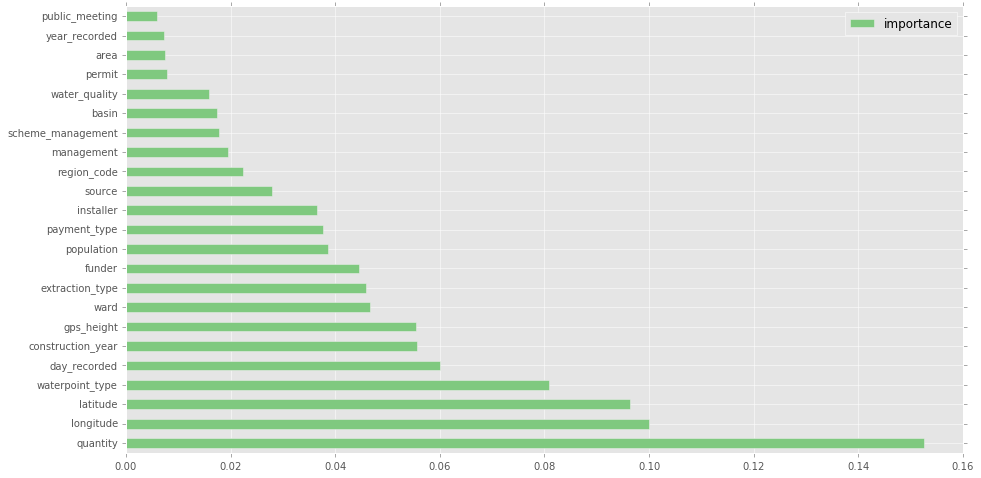

In [12]:
df = pd.DataFrame({'importance' : rf_clf.feature_importances_}, index = features)
df.sort_values(by='importance', ascending=False ).plot(kind='barh',colormap ='Accent', figsize=(15,8))